In [1]:
import torch
import math
from einops import repeat
import torch.nn as nn


In [2]:
import numpy as np
def hippo_LegS_1(n):
    #will return the hippo-legs matrix used in s4
    A = np.zeros((n,n))
    B = np.array([math.sqrt(2*i+1) for i in range(n)]).reshape(-1,1)
    for i in range(n):
        for j in range(n):
            if i == j:
                A[i,j] = -(i+1)
            if i < j:
                A[i,j] = 0
            if i > j:
                A[i,j] = -math.sqrt((2*i+1)*(2*j+1))
    return A,B

def hippo_LegS_dplr(n):
    #returns the diagonal-plus-low-rank matrix 
    A_n = np.zeros((n,n))
    P = np.array([math.sqrt(i+1/2) for i in range(n)]).reshape(-1,1)
    for i in range(n):
        for j in range(n):
            if i == j:
                A_n[i,j] = -1/2
            else:
                A_n[i,j] = -math.sqrt((i+1/2)*(j+1/2))
    PPT = P @ P.T
    A = A_n - PPT
    A_d = np.linalg.eigvals(A)
    return A, A_d

def zero_order_hold(A,B,dt):
    da = np.exp(A * dt)
    db = np.dot(np.linalg.inv(A * dt) * (da - np.identity(A.shape[0])), dt*B)
    return da, db

def bilinear(A,B,dt):
    id = np.identity(A.shape[0])
    inv = np.linalg.inv(id - dt * A / 2)
    da = inv @ (id + dt * A / 2)
    db = inv @ B * dt
    return da, db

A,B = hippo_LegS_1(5)
A1,A1_d = hippo_LegS_dplr(5)
print(A)
print(A1)
print(A1_d)

da,db = zero_order_hold(A,B,0.1)
da1,db1 = bilinear(A,B,0.1)


[[-1.          0.          0.          0.          0.        ]
 [-1.73205081 -2.          0.          0.          0.        ]
 [-2.23606798 -3.87298335 -3.          0.          0.        ]
 [-2.64575131 -4.58257569 -5.91607978 -4.          0.        ]
 [-3.         -5.19615242 -6.70820393 -7.93725393 -5.        ]]
[[-1.         -1.73205081 -2.23606798 -2.64575131 -3.        ]
 [-1.73205081 -2.         -3.87298335 -4.58257569 -5.19615242]
 [-2.23606798 -3.87298335 -3.         -5.91607978 -6.70820393]
 [-2.64575131 -4.58257569 -5.91607978 -4.         -7.93725393]
 [-3.         -5.19615242 -6.70820393 -7.93725393 -5.        ]]
[-22.25614697   0.10302733   3.52700511   2.37838424   1.24773029]


In [3]:
from einops import einsum
#numpy versions of the code
def discretize(log_dt,log_A_real,A_imag,B):
    #update this to be n-dimensional
    
    dt, A = np.exp(log_dt), -np.exp(log_A_real) + 1j * A_imag

    dtA = einsum(dt,A, 'n, n h -> n h')
    dtB = einsum(dt,B, 'n, n h -> n h')

    dA = (1 + dtA / 2) / (1 - dtA / 2)
    dB = dtB / (1 - dtA/2)

    # dA, dB = (1+dt * A/2) / (1 - dt * A/2), dt * B / (1 - dt * A/2)

    return dA, dB

def nd_s4d(n_inputs,n_states_per_input,dt_min=1e-3,dt_max=1e-1):

    log_dt = np.random.rand(n_inputs) * (np.log(dt_max) - np.log(dt_min)) + np.log(dt_min)
    A = -0.5 + 1j * np.pi * np.arange(n_states_per_input//2)
    A = np.concatenate([A,np.conj(A[::-1])])
    #repeat this across a new dimension for each input
    A = np.repeat(A[np.newaxis,:], n_inputs, axis=0)
    B = np.ones((n_inputs,n_states_per_input)) + 0j
    C = np.random.randn(n_inputs,n_states_per_input) + 1j * np.random.randn(n_inputs,n_states_per_input)
    
    return log_dt, np.log(-A.real), A.imag, B, C


def forward_nd(us,dA,dB,C):
    #num_dimensions is the number of dimensions in the input
    #num_states is the number of dimensions of the SSM per each input
    #us has input (num_dimensions, time (L))
    #dA has shape (num_dimensions, num_states) (diagonal)
    #dB has shape (num_dimensions, num_states)
    #C has shape (num_dimensions, num_states, 1)
    L = us.shape[-1]
    xs = np.zeros((*dA.shape,L),dtype=np.complex128) #num_dimensions, num_states, time
    ys = np.zeros((us.shape[0],L),dtype=np.complex128) #num_dimensions, time)
    inp = einsum(dB,us,'d n, d t -> d n t')
    for i in range(L):
        xs[:,:,i] = dA * xs[:,:,i-1] + inp[:,:,i]
        ys[:,i] = einsum(C,xs[:,:,i],'d n, d n -> d')
    
    return xs, ys.real
    

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from einops import einsum,repeat
import math
import torch

class S4D_rnn(nn.Module):
    #this computes an s4d model 
    def __init__(self,n_inputs,n_states_per_input,dt_min=1e-3,dt_max=1e-1,seed=None,lr=None,noC=False):
        super().__init__()

        self.noC = noC
        if seed is not None:
            torch.random.seed(seed)

        log_dt = torch.rand(n_inputs) * (math.log(dt_max) - math.log(dt_min)) + np.log(dt_min)
        self.register("log_dt",log_dt,lr)
        
        log_A_real = torch.log(0.5 * torch.ones(n_inputs, n_states_per_input // 2))
        A_imag = math.pi * repeat(torch.arange(n_states_per_input//2), 'n -> h n', h=n_inputs)

        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

        B = torch.ones((n_inputs,n_states_per_input)) + 0j
        self.register("B",B,lr)
        
        C = torch.rand(n_inputs,n_states_per_input // 2) + 1j * torch.rand(n_inputs,n_states_per_input // 2)
        self.register("C",C,lr)

    def discretize(self,log_dt,log_A_real,A_imag,B):
    
        dt, A = torch.exp(log_dt), -torch.exp(log_A_real) + 1j * A_imag

        dtA = einsum(dt,A, 'n, n h -> n h')
        dtB = einsum(dt,B, 'n, n h -> n h')

        dA = (1 + dtA / 2) / (1 - dtA / 2)
        dB = dtB / (1 - dtA/2)

        return dA, dB

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

    def forward(self,us,rnn=True):
        #num_dimensions is the number of dimensions in the input
        #num_states is the number of dimensions of the SSM per each input
        #us has input (num_dimensions, time (L)) or (batch, num_dim, time)
        #dA has shape (num_dimensions, num_states) (diagonal)
        #dB has shape (num_dimensions, num_states)
        #C has shape (num_dimensions, num_states, 1)
        if len(us.shape) == 2:
            us = us.unsqueeze(0)

        b,nd,L = us.shape
        device = us.device
        #expand A_imag and log_A_real to include complex conjugates (do here so weights are tied)
        A_imag = torch.cat([self.A_imag, -self.A_imag], dim=1)
        #double log_A_real to match
        log_A_real = torch.cat([self.log_A_real, self.log_A_real], dim=1)

        dA, dB = self.discretize(self.log_dt, log_A_real, A_imag, self.B)

        nstates = dA.shape[-1]
        L = us.shape[-1]

        if rnn:
            C = torch.cat([self.C, self.C], dim=1)
            # xs = torch.zeros((b, nd, nstates, L),dtype=torch.complex64) #num_dimensions, num_states, time
            xs = torch.zeros((b, nd,nstates),dtype=torch.complex64).to(device) #num_dimensions, num_states, time
            all_xs = []
            if self.noC:
                ys = torch.zeros((b, nd,nstates//2, L), dtype=torch.complex64).to(device)
            else:
                ys = torch.zeros((b, nd, L), dtype=torch.complex64).to(device) #num_dimensions, time)
            inp = einsum(dB,us,'d n, b d t -> b d n t')
            for i in range(L):
                xs = einsum(dA, xs, 'd n, b d n -> b d n') + inp[:,:,:,i]
                all_xs.append(torch.clone(xs))

                if self.noC:
                    ys[:,:,:,i] = xs[:,:,:nstates//2] #only take the first half, second half is repeated with conj pairs
                else:
                    ys[:,:,i] = einsum(C,xs,'d n, b d n -> b d')
            
            all_xs = torch.stack(all_xs,dim=-1)

            return all_xs, ys.real

        else:
            #compute the kernel, then convolve
            dt = torch.exp(self.log_dt) # (H)
            A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

            # Vandermonde multiplication
            dtA = A * dt.unsqueeze(-1)  # (H N)
            K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)

            if self.noC:
                k_no_c = 2 * torch.exp(K).real
                ys = []

                u_f = torch.fft.rfft(us, n=2*L) # (B H L)
                for kk in range(k_no_c.shape[1]):
                    k_f = torch.fft.rfft(k_no_c[:,kk], n=2*L) # (H L)
                    y_k = torch.fft.irfft(u_f*k_f, n=2*L)[..., :L] # (B H L)
                    ys.append(y_k)

                y = torch.stack(ys,dim=1)

            else:
                C = self.C * (torch.exp(dtA)-1.) / A
                #no multiplying by 2 here because we plugged in the conjugate
                
                k = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real

                # Convolution
                k_f = torch.fft.rfft(k, n=2*L) # (H L)
                u_f = torch.fft.rfft(us, n=2*L) # (B H L)
                y = torch.fft.irfft(u_f*k_f, n=2*L)[..., :L] # (B H L)

            return None, y


torch.Size([4, 1, 1000])


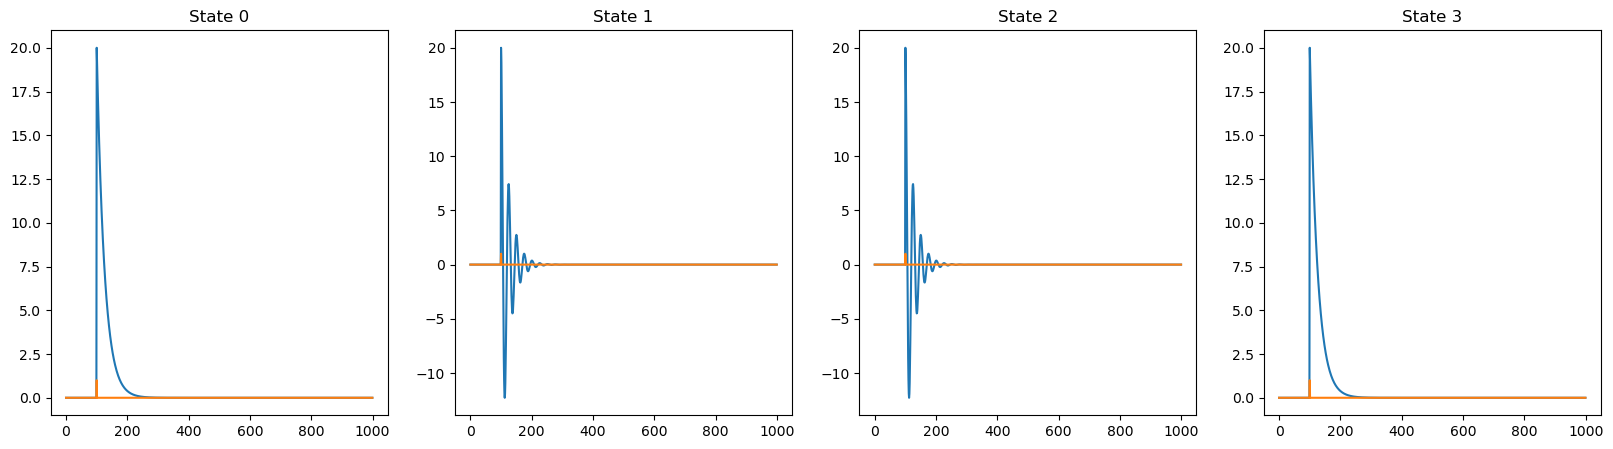

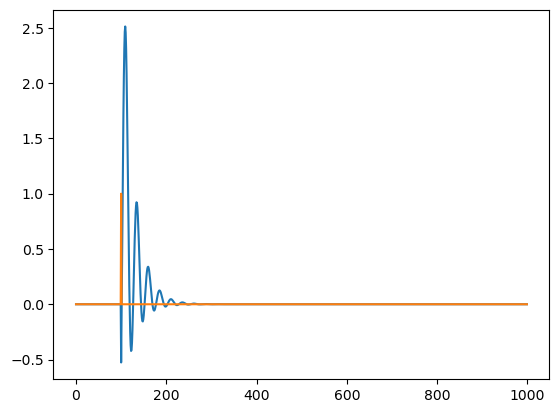

In [63]:
n_inps = 1
nd = 4
log_dts, log_A_reals, A_imags, Bs, Cs = nd_s4d(n_inps,nd)
dA, dB = discretize(log_dts,log_A_reals,A_imags,Bs)
L = 1000
u = np.zeros((n_inps,L))
u[0,100:101] = 10
# u[1,3:4] = 10

log_dts = torch.tensor(log_dts)
log_A_reals = torch.tensor(log_A_reals)
A_imags = torch.tensor(A_imags)
Bs = torch.tensor(Bs)
Cs = torch.tensor(Cs)
u = torch.tensor(u)

#compute the kernel, then convolve
dt = torch.exp(log_dts) # (H)
# C = torch.view_as_complex(self.C) # (H N)
A = -torch.exp(log_A_reals) + 1j * A_imags # (H N)

# Vandermonde multiplication
dtA = A * dt.unsqueeze(-1)  # (H N)
K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
C = Cs * (torch.exp(dtA)-1.) / A
#no multiplying by 2 here because we plugged in the conjugate
k = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real
k_no_c = 2 * torch.exp(K).real
ys = []

u_f = torch.fft.rfft(u, n=2*L) # (B H L)
for kk in range(k_no_c.shape[1]):
    k_f = torch.fft.rfft(k_no_c[:,kk], n=2*L) # (H L)
    y_k = torch.fft.irfft(u_f*k_f, n=2*L)[..., :L] # (B H L)
    ys.append(y_k)

ys = torch.stack(ys,dim=0)
print(ys.shape)

fig,ax = plt.subplots(1,nd, figsize=(nd*5,5))
for i in range(nd):
    ax[i].plot(ys[i,0].numpy())
    ax[i].plot(u[0]*0.1)
    ax[i].set_title(f"State {i}")

# Convolution
k_f = torch.fft.rfft(k, n=2*L) # (H L)
u_f = torch.fft.rfft(u, n=2*L) # (B H L)
y = torch.fft.irfft(u_f*k_f, n=2*L)[..., :L] # (B H L)

plt.figure()
plt.plot(y[0,].numpy())
plt.plot(u[0]*0.1)

(2, 4)
[[0.99676085+0.j         0.9965541 +0.02031712j 0.9965541 -0.02031712j
  0.99676085+0.j        ]
 [0.99819295+0.j         0.99812856+0.01134338j 0.99812856-0.01134338j
  0.99819295+0.j        ]]
(2, 4, 1000) (2, 1000)


/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


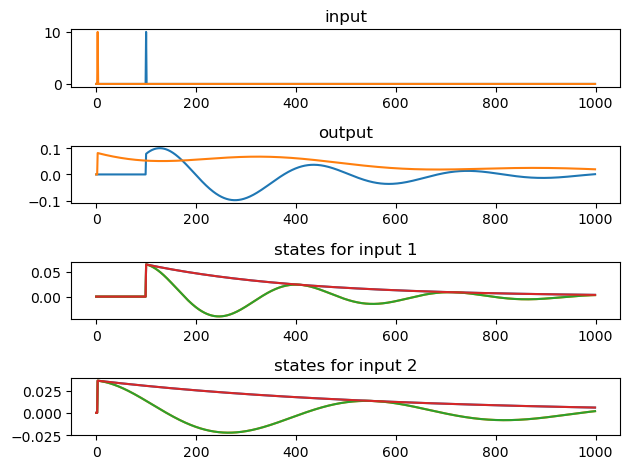

In [56]:
n_inps = 2
log_dts, log_A_reals, A_imags, Bs, Cs = nd_s4d(n_inps,4)
print(Cs.shape)
dA, dB = discretize(log_dts, log_A_reals,A_imags,Bs)
print(dA)
L = 1000
u = np.zeros((n_inps,L))
u[0,100:101] = 10
u[1,3:4] = 10

xs, ys = forward_nd(u,dA,dB,Cs)
print(xs.shape,ys.shape)

def plot_uxy(u,xs,ys):
    if xs is not None:
        fig,ax = plt.subplots(4,1)
    else:
        fig, ax = plt.subplots(2,1)
    ax[0].plot(u.T)
    ax[0].set_title("input")
    ax[1].plot(ys.T)
    ax[1].set_title("output")
    if xs is not None:
        ax[2].set_title("states for input 1")
        ax[2].plot(xs[0].T)
        ax[3].set_title("states for input 2")
        ax[3].plot(xs[1].T)
    plt.tight_layout()

plot_uxy(u,xs,ys)

(2, 1000)


/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


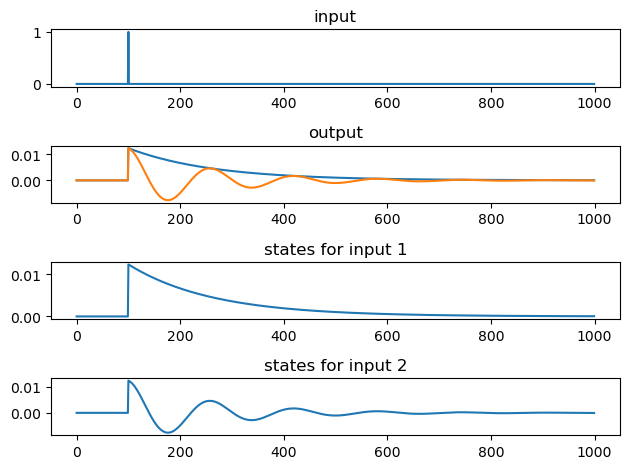

In [67]:
L = 1000
n_inps = 1
u = torch.zeros((n_inps,L))
u[0,100:101] = 1
# u[1,3:4] = 1

s4d = S4D_rnn(n_inputs=n_inps,n_states_per_input=4,noC=True)

xs, ys = s4d(u,rnn=True)

u = u.detach().numpy()
if xs is not None:
    xs = xs.detach().numpy().squeeze()
ys = ys.detach().numpy().squeeze()

print(ys.shape)
plot_uxy(u,xs,ys)

In [74]:
class S4DMinimal(nn.Module):
    def __init__(self,d_input,d_output,d_model,d_state,dropout=0.0,prenorm=False,expansion=4,noC=False):
        super().__init__()
        self.noC = noC
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input,d_model)
        self.s4 = S4D_rnn(n_inputs=d_model,n_states_per_input=d_state,noC=noC)
        if self.noC: #if we return all A's (the delay embedded formulation)
            self.dm = d_state * d_model // 2 #dividing by 2 bc of conjugate pairs
        else:
            self.dm = d_model


        self.norm = nn.LayerNorm(self.dm) if not prenorm else nn.LayerNorm(d_model)
        self.droppout = nn.Dropout(dropout)

        # self.decoder = nn.Linear(dm,d_output)

        self.decoder = nn.Sequential(
            nn.Linear(self.dm,expansion*self.dm),
            nn.ReLU(),
            nn.Linear(expansion*self.dm,d_output)
        )

        self.rnn = False

    def forward(self,x):
        u = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
        b,l,dinp = u.shape 

        u = u.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)

        if self.prenorm:
            # Prenorm
            u = self.norm(u.transpose(-1, -2)).transpose(-1, -2)

        # Apply S4 block: we ignore the state input and output
        xs, ys = self.s4(u,rnn = self.rnn)
        self.ssm_states = xs
        self.ssm_outs = ys

        ys = ys.transpose(-1, -2)  # (B, d_model, L) -> (B, L, d_model)
        u = u.transpose(-1, -2)
        # Residual connection
        if self.noC:
            zs = ys.reshape(b,l,self.dm) 
            #u won't be the right dimension, and besides, we already have this in y
            #also,flatten each ssm output
        else:
            zs = ys + u # B, L, d_model

        if not self.prenorm:
            # Postnorm
            zs = self.norm(zs)

        # zs = zs.transpose(-1, -2) # B, d_model, L

        # Decode the outputs
        zs = self.decoder(zs)  # (B, L, d_model) -> (B, L, d_output)

        return zs, xs

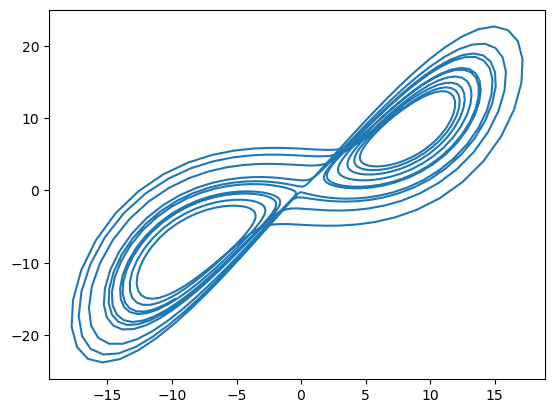

In [9]:
from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(1000, resample=True,noise=0.00)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])


In [10]:
from utils import make_dataset,train

train_loader, val_loader, train_data, val_data = make_dataset(Lorenz,500,10)


(10, 500, 3) torch.Size([10, 500, 1])
(10, 500, 3) torch.Size([10, 500, 1])


In [75]:
data = next(iter(train_loader))

noC = True
model = S4DMinimal(1,1,2,10,noC=noC)
model.rnn = True
out,hiddens = model(data)

print(data.shape,out.shape)
if hiddens is not None:
    print(hiddens.shape)

torch.Size([1, 500, 1]) torch.Size([1, 500, 1])
torch.Size([1, 2, 10, 500])


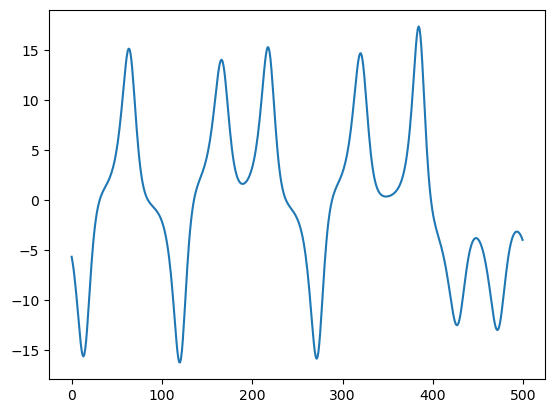

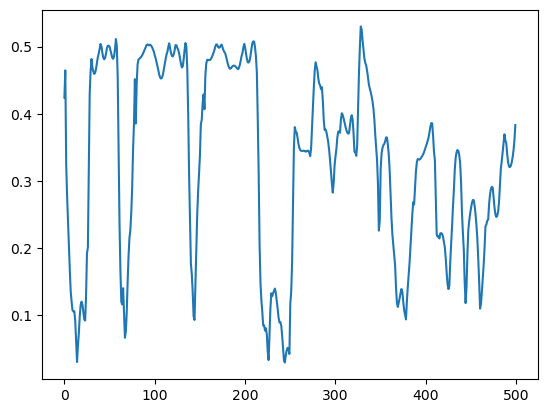

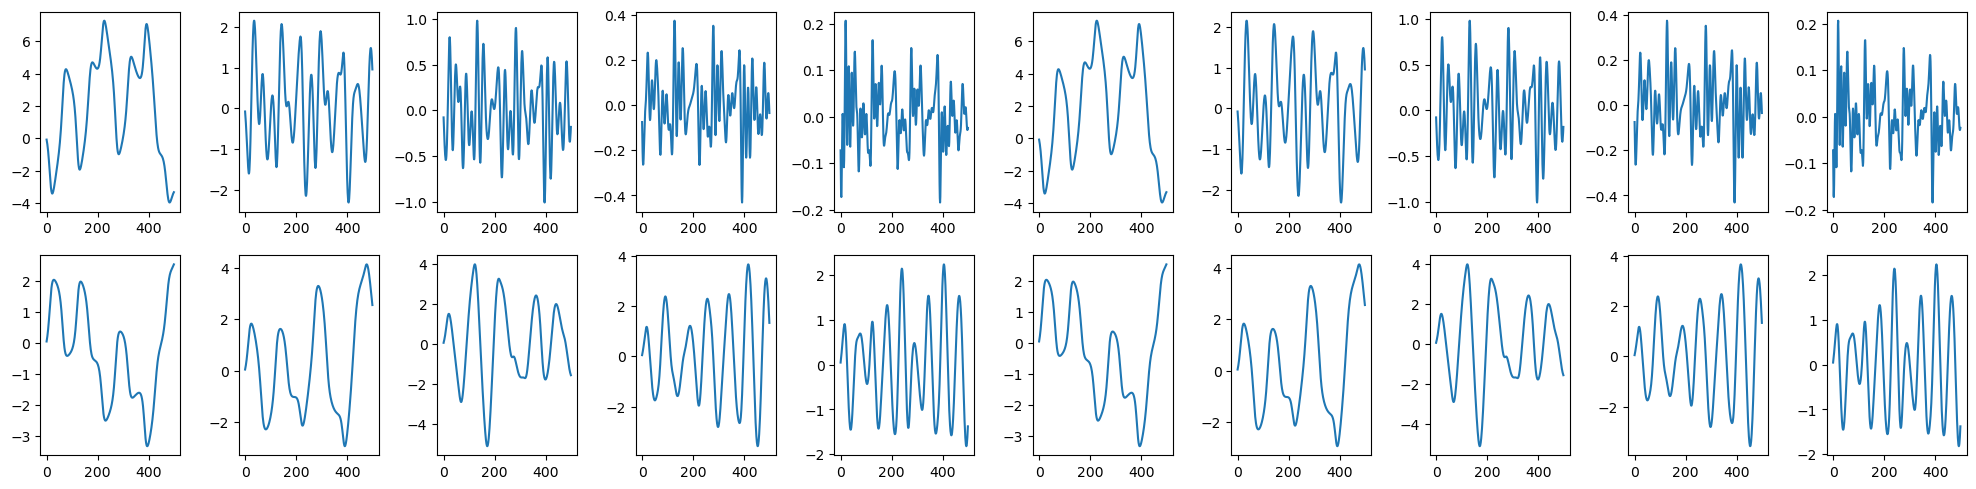

In [76]:
plt.plot(data[0,:,0])
plt.figure()
plt.plot(out[0,:,0].detach().numpy())

fig, ax = plt.subplots(hiddens.shape[1],hiddens.shape[2],figsize=(20,5))
if hiddens.shape[1] == 1:
    ax = np.array([ax])
for i in range(hiddens.shape[1]):
    for j in range(hiddens.shape[2]):
        ax[i,j].plot(hiddens[0,i,j].detach().numpy())

plt.tight_layout()

In [77]:
from torch.optim import AdamW

model = S4DMinimal(1,1,1,50,expansion=4,noC=True)
#model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
all_train_loss = []
all_val_loss = []
for num_steps in [1,2,3]:
    model, train_loss, val_loss = train(model, train_loader, val_loader, 100, 5e-3,AdamW, nn.MSELoss(), 'cuda',num_steps)
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-3,AdamW, nn.MSELoss(), 'cuda',num_steps)
    all_train_loss.extend(train_loss)
    all_val_loss.extend(val_loss)

plt.plot(all_train_loss)
plt.plot(all_val_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<01:56,  1.18s/it]

Epoch 0 Training Loss: 63.71591033935547
Epoch 0 Validation Loss: 60.47216720581055


  2%|▏         | 2/100 [00:01<01:00,  1.62it/s]

Epoch 1 Training Loss: 61.48006896972656
Epoch 1 Validation Loss: 60.03774528503418


  3%|▎         | 3/100 [00:01<00:42,  2.28it/s]

Epoch 2 Training Loss: 61.56124382019043
Epoch 2 Validation Loss: 59.35801811218262


  4%|▍         | 4/100 [00:01<00:33,  2.83it/s]

Epoch 3 Training Loss: 61.84871253967285
Epoch 3 Validation Loss: 59.51599349975586


  5%|▌         | 5/100 [00:02<00:28,  3.28it/s]

Epoch 4 Training Loss: 60.91653633117676
Epoch 4 Validation Loss: 58.88056526184082


  6%|▌         | 6/100 [00:02<00:25,  3.63it/s]

Epoch 5 Training Loss: 60.599951171875
Epoch 5 Validation Loss: 58.822719192504884


  7%|▋         | 7/100 [00:02<00:23,  3.89it/s]

Epoch 6 Training Loss: 60.56580009460449
Epoch 6 Validation Loss: 58.82421875


  8%|▊         | 8/100 [00:02<00:22,  4.07it/s]

Epoch 7 Training Loss: 60.47946739196777
Epoch 7 Validation Loss: 58.792328643798825


  9%|▉         | 9/100 [00:02<00:21,  4.20it/s]

Epoch 8 Training Loss: 60.3389835357666
Epoch 8 Validation Loss: 58.65614814758301


 10%|█         | 10/100 [00:03<00:20,  4.31it/s]

Epoch 9 Training Loss: 60.29494400024414
Epoch 9 Validation Loss: 58.77649841308594


 11%|█         | 11/100 [00:03<00:20,  4.36it/s]

Epoch 10 Training Loss: 60.51704978942871
Epoch 10 Validation Loss: 58.72596435546875


 12%|█▏        | 12/100 [00:03<00:19,  4.42it/s]

Epoch 11 Training Loss: 60.187238693237305
Epoch 11 Validation Loss: 58.61395606994629


 13%|█▎        | 13/100 [00:03<00:19,  4.48it/s]

Epoch 12 Training Loss: 60.84693946838379
Epoch 12 Validation Loss: 58.38975028991699


 14%|█▍        | 14/100 [00:04<00:18,  4.53it/s]

Epoch 13 Training Loss: 60.62869300842285
Epoch 13 Validation Loss: 58.831169509887694


 15%|█▌        | 15/100 [00:04<00:18,  4.54it/s]

Epoch 14 Training Loss: 60.225747680664064
Epoch 14 Validation Loss: 58.5482292175293


 16%|█▌        | 16/100 [00:04<00:18,  4.54it/s]

Epoch 15 Training Loss: 60.430898666381836
Epoch 15 Validation Loss: 58.3062858581543


 17%|█▋        | 17/100 [00:04<00:18,  4.58it/s]

Epoch 16 Training Loss: 60.210347747802736
Epoch 16 Validation Loss: 58.47414436340332


 18%|█▊        | 18/100 [00:04<00:17,  4.60it/s]

Epoch 17 Training Loss: 60.424608612060545
Epoch 17 Validation Loss: 58.35517616271973


 19%|█▉        | 19/100 [00:05<00:17,  4.59it/s]

Epoch 18 Training Loss: 60.14900932312012
Epoch 18 Validation Loss: 58.59185562133789


 20%|██        | 20/100 [00:05<00:17,  4.59it/s]

Epoch 19 Training Loss: 60.1966064453125
Epoch 19 Validation Loss: 58.66436996459961


 21%|██        | 21/100 [00:05<00:17,  4.60it/s]

Epoch 20 Training Loss: 60.04077377319336
Epoch 20 Validation Loss: 58.602072143554686


 22%|██▏       | 22/100 [00:05<00:16,  4.62it/s]

Epoch 21 Training Loss: 60.23381309509277
Epoch 21 Validation Loss: 58.37326507568359


 23%|██▎       | 23/100 [00:05<00:16,  4.62it/s]

Epoch 22 Training Loss: 59.97962112426758
Epoch 22 Validation Loss: 58.24292144775391


 24%|██▍       | 24/100 [00:06<00:16,  4.62it/s]

Epoch 23 Training Loss: 60.7126277923584
Epoch 23 Validation Loss: 58.047949981689456


 25%|██▌       | 25/100 [00:06<00:16,  4.61it/s]

Epoch 24 Training Loss: 60.1052734375
Epoch 24 Validation Loss: 58.42271461486816


 26%|██▌       | 26/100 [00:06<00:16,  4.59it/s]

Epoch 25 Training Loss: 60.27910041809082
Epoch 25 Validation Loss: 58.67011909484863


 27%|██▋       | 27/100 [00:06<00:15,  4.60it/s]

Epoch 26 Training Loss: 60.366970443725585
Epoch 26 Validation Loss: 58.0800895690918


 28%|██▊       | 28/100 [00:07<00:15,  4.59it/s]

Epoch 27 Training Loss: 59.701480865478516
Epoch 27 Validation Loss: 58.16919097900391


 29%|██▉       | 29/100 [00:07<00:15,  4.60it/s]

Epoch 28 Training Loss: 59.76573257446289
Epoch 28 Validation Loss: 58.14317932128906


 30%|███       | 30/100 [00:07<00:15,  4.41it/s]

Epoch 29 Training Loss: 60.04056243896484
Epoch 29 Validation Loss: 58.152671813964844


 31%|███       | 31/100 [00:07<00:15,  4.40it/s]

Epoch 30 Training Loss: 60.06408767700195
Epoch 30 Validation Loss: 58.44692497253418


 32%|███▏      | 32/100 [00:08<00:15,  4.40it/s]

Epoch 31 Training Loss: 59.811273193359376
Epoch 31 Validation Loss: 58.064545440673825


 33%|███▎      | 33/100 [00:08<00:15,  4.44it/s]

Epoch 32 Training Loss: 61.07971305847168
Epoch 32 Validation Loss: 58.741186904907224


 34%|███▍      | 34/100 [00:08<00:14,  4.47it/s]

Epoch 33 Training Loss: 59.862538528442386
Epoch 33 Validation Loss: 58.210382080078126


 35%|███▌      | 35/100 [00:08<00:14,  4.51it/s]

Epoch 34 Training Loss: 59.698919677734374
Epoch 34 Validation Loss: 57.983391189575194


 36%|███▌      | 36/100 [00:08<00:14,  4.27it/s]

Epoch 35 Training Loss: 60.065286254882814
Epoch 35 Validation Loss: 57.88872871398926


 37%|███▋      | 37/100 [00:09<00:14,  4.33it/s]

Epoch 36 Training Loss: 59.425255584716794
Epoch 36 Validation Loss: 58.08917503356933


 38%|███▊      | 38/100 [00:09<00:14,  4.37it/s]

Epoch 37 Training Loss: 59.51040763854981
Epoch 37 Validation Loss: 58.25052108764648


 39%|███▉      | 39/100 [00:09<00:13,  4.41it/s]

Epoch 38 Training Loss: 59.86715545654297
Epoch 38 Validation Loss: 58.198913955688475


 40%|████      | 40/100 [00:09<00:13,  4.42it/s]

Epoch 39 Training Loss: 59.55044174194336
Epoch 39 Validation Loss: 58.250274658203125


 41%|████      | 41/100 [00:10<00:13,  4.44it/s]

Epoch 40 Training Loss: 59.6077278137207
Epoch 40 Validation Loss: 58.07196731567383


 42%|████▏     | 42/100 [00:10<00:12,  4.47it/s]

Epoch 41 Training Loss: 59.346064758300784
Epoch 41 Validation Loss: 58.032603073120114


 43%|████▎     | 43/100 [00:10<00:12,  4.51it/s]

Epoch 42 Training Loss: 59.69234428405762
Epoch 42 Validation Loss: 57.84930191040039


 44%|████▍     | 44/100 [00:10<00:12,  4.54it/s]

Epoch 43 Training Loss: 59.56831436157226
Epoch 43 Validation Loss: 58.11385231018066


 45%|████▌     | 45/100 [00:10<00:12,  4.56it/s]

Epoch 44 Training Loss: 60.600270462036136
Epoch 44 Validation Loss: 57.82519454956055


 46%|████▌     | 46/100 [00:11<00:11,  4.58it/s]

Epoch 45 Training Loss: 59.48176155090332
Epoch 45 Validation Loss: 58.27990913391113


 47%|████▋     | 47/100 [00:11<00:11,  4.59it/s]

Epoch 46 Training Loss: 59.82646713256836
Epoch 46 Validation Loss: 58.621019744873045


 48%|████▊     | 48/100 [00:11<00:11,  4.59it/s]

Epoch 47 Training Loss: 59.45580062866211
Epoch 47 Validation Loss: 57.974813079833986


 49%|████▉     | 49/100 [00:11<00:11,  4.60it/s]

Epoch 48 Training Loss: 59.61204948425293
Epoch 48 Validation Loss: 58.07147789001465


 50%|█████     | 50/100 [00:12<00:10,  4.60it/s]

Epoch 49 Training Loss: 60.284429931640624
Epoch 49 Validation Loss: 57.78363952636719


 51%|█████     | 51/100 [00:12<00:10,  4.61it/s]

Epoch 50 Training Loss: 59.16998710632324
Epoch 50 Validation Loss: 58.04252548217774


 52%|█████▏    | 52/100 [00:12<00:10,  4.64it/s]

Epoch 51 Training Loss: 59.702293395996094
Epoch 51 Validation Loss: 58.30227088928223


 53%|█████▎    | 53/100 [00:12<00:10,  4.66it/s]

Epoch 52 Training Loss: 59.59868545532227
Epoch 52 Validation Loss: 57.928646850585935


 54%|█████▍    | 54/100 [00:12<00:09,  4.66it/s]

Epoch 53 Training Loss: 59.257119750976564
Epoch 53 Validation Loss: 57.80324478149414


 55%|█████▌    | 55/100 [00:13<00:09,  4.66it/s]

Epoch 54 Training Loss: 59.36719818115235
Epoch 54 Validation Loss: 57.99568176269531


 56%|█████▌    | 56/100 [00:13<00:09,  4.67it/s]

Epoch 55 Training Loss: 59.23536605834961
Epoch 55 Validation Loss: 58.01707496643066


 57%|█████▋    | 57/100 [00:13<00:09,  4.67it/s]

Epoch 56 Training Loss: 59.36540832519531
Epoch 56 Validation Loss: 57.70719757080078


 58%|█████▊    | 58/100 [00:13<00:08,  4.69it/s]

Epoch 57 Training Loss: 59.22610015869141
Epoch 57 Validation Loss: 57.8876392364502


 59%|█████▉    | 59/100 [00:13<00:08,  4.72it/s]

Epoch 58 Training Loss: 59.24697074890137
Epoch 58 Validation Loss: 57.986537551879884


 60%|██████    | 60/100 [00:14<00:08,  4.74it/s]

Epoch 59 Training Loss: 59.596968460083005
Epoch 59 Validation Loss: 57.61740951538086


 61%|██████    | 61/100 [00:14<00:08,  4.60it/s]

Epoch 60 Training Loss: 59.33956871032715
Epoch 60 Validation Loss: 57.81070671081543


 62%|██████▏   | 62/100 [00:14<00:08,  4.62it/s]

Epoch 61 Training Loss: 59.52478561401367
Epoch 61 Validation Loss: 57.9220588684082


 63%|██████▎   | 63/100 [00:14<00:08,  4.61it/s]

Epoch 62 Training Loss: 59.35901069641113
Epoch 62 Validation Loss: 57.66795120239258


 64%|██████▍   | 64/100 [00:15<00:07,  4.65it/s]

Epoch 63 Training Loss: 59.41824836730957
Epoch 63 Validation Loss: 57.96173934936523


 65%|██████▌   | 65/100 [00:15<00:07,  4.65it/s]

Epoch 64 Training Loss: 59.36872253417969
Epoch 64 Validation Loss: 57.92979393005371


 66%|██████▌   | 66/100 [00:15<00:07,  4.65it/s]

Epoch 65 Training Loss: 59.80678825378418
Epoch 65 Validation Loss: 57.55401191711426


 67%|██████▋   | 67/100 [00:15<00:07,  4.67it/s]

Epoch 66 Training Loss: 59.543025970458984
Epoch 66 Validation Loss: 58.06300773620605


 68%|██████▊   | 68/100 [00:15<00:06,  4.69it/s]

Epoch 67 Training Loss: 59.16394157409668
Epoch 67 Validation Loss: 57.80204811096191


 69%|██████▉   | 69/100 [00:16<00:06,  4.71it/s]

Epoch 68 Training Loss: 58.977425765991214
Epoch 68 Validation Loss: 57.62492561340332


 70%|███████   | 70/100 [00:16<00:06,  4.71it/s]

Epoch 69 Training Loss: 59.814306640625
Epoch 69 Validation Loss: 58.02022132873535


 71%|███████   | 71/100 [00:16<00:06,  4.70it/s]

Epoch 70 Training Loss: 58.77339668273926
Epoch 70 Validation Loss: 57.65340042114258


 72%|███████▏  | 72/100 [00:16<00:05,  4.69it/s]

Epoch 71 Training Loss: 59.30136833190918
Epoch 71 Validation Loss: 57.56125259399414


 73%|███████▎  | 73/100 [00:16<00:05,  4.67it/s]

Epoch 72 Training Loss: 60.10613098144531
Epoch 72 Validation Loss: 57.68247604370117


 74%|███████▍  | 74/100 [00:17<00:05,  4.67it/s]

Epoch 73 Training Loss: 58.94098434448242
Epoch 73 Validation Loss: 57.5990665435791


 75%|███████▌  | 75/100 [00:17<00:05,  4.68it/s]

Epoch 74 Training Loss: 60.2853702545166
Epoch 74 Validation Loss: 58.72538070678711


 76%|███████▌  | 76/100 [00:17<00:05,  4.68it/s]

Epoch 75 Training Loss: 59.14366455078125
Epoch 75 Validation Loss: 58.13419952392578


 77%|███████▋  | 77/100 [00:17<00:04,  4.71it/s]

Epoch 76 Training Loss: 59.80849723815918
Epoch 76 Validation Loss: 57.48203887939453


 78%|███████▊  | 78/100 [00:17<00:04,  4.71it/s]

Epoch 77 Training Loss: 58.984289932250974
Epoch 77 Validation Loss: 57.86092529296875


 79%|███████▉  | 79/100 [00:18<00:04,  4.71it/s]

Epoch 78 Training Loss: 58.933615112304686
Epoch 78 Validation Loss: 57.677269744873044


 80%|████████  | 80/100 [00:18<00:04,  4.75it/s]

Epoch 79 Training Loss: 59.57664451599121
Epoch 79 Validation Loss: 58.080780029296875


 81%|████████  | 81/100 [00:18<00:03,  4.77it/s]

Epoch 80 Training Loss: 58.84592514038086
Epoch 80 Validation Loss: 57.61553764343262


 82%|████████▏ | 82/100 [00:18<00:03,  4.78it/s]

Epoch 81 Training Loss: 59.00464096069336
Epoch 81 Validation Loss: 57.67283134460449


 83%|████████▎ | 83/100 [00:19<00:03,  4.81it/s]

Epoch 82 Training Loss: 59.47542114257813
Epoch 82 Validation Loss: 57.978715896606445


 84%|████████▍ | 84/100 [00:19<00:03,  4.62it/s]

Epoch 83 Training Loss: 59.048546600341794
Epoch 83 Validation Loss: 57.49385643005371


 85%|████████▌ | 85/100 [00:19<00:03,  4.62it/s]

Epoch 84 Training Loss: 59.105797576904294
Epoch 84 Validation Loss: 57.52781524658203


 86%|████████▌ | 86/100 [00:19<00:03,  4.62it/s]

Epoch 85 Training Loss: 59.06701583862305
Epoch 85 Validation Loss: 57.99353675842285


 87%|████████▋ | 87/100 [00:19<00:02,  4.57it/s]

Epoch 86 Training Loss: 58.812875747680664
Epoch 86 Validation Loss: 57.756568908691406


 88%|████████▊ | 88/100 [00:20<00:02,  4.58it/s]

Epoch 87 Training Loss: 58.95765075683594
Epoch 87 Validation Loss: 57.57254295349121


 89%|████████▉ | 89/100 [00:20<00:02,  4.56it/s]

Epoch 88 Training Loss: 58.99357872009277
Epoch 88 Validation Loss: 57.54541435241699


 90%|█████████ | 90/100 [00:20<00:02,  4.54it/s]

Epoch 89 Training Loss: 58.82017288208008
Epoch 89 Validation Loss: 57.64821510314941


 91%|█████████ | 91/100 [00:20<00:01,  4.52it/s]

Epoch 90 Training Loss: 58.90515060424805
Epoch 90 Validation Loss: 57.91118965148926


 92%|█████████▏| 92/100 [00:21<00:01,  4.52it/s]

Epoch 91 Training Loss: 58.92083587646484
Epoch 91 Validation Loss: 57.603573608398435


 93%|█████████▎| 93/100 [00:21<00:01,  4.51it/s]

Epoch 92 Training Loss: 58.925086975097656
Epoch 92 Validation Loss: 57.81309051513672


 94%|█████████▍| 94/100 [00:21<00:01,  4.52it/s]

Epoch 93 Training Loss: 58.71174697875976
Epoch 93 Validation Loss: 57.56312446594238


 95%|█████████▌| 95/100 [00:21<00:01,  4.52it/s]

Epoch 94 Training Loss: 59.11871070861817
Epoch 94 Validation Loss: 57.86940231323242


 96%|█████████▌| 96/100 [00:21<00:00,  4.56it/s]

Epoch 95 Training Loss: 58.67448387145996
Epoch 95 Validation Loss: 57.392116165161134


 97%|█████████▋| 97/100 [00:22<00:00,  4.58it/s]

Epoch 96 Training Loss: 59.416636276245114
Epoch 96 Validation Loss: 57.399213790893555


 98%|█████████▊| 98/100 [00:22<00:00,  4.60it/s]

Epoch 97 Training Loss: 59.4275463104248
Epoch 97 Validation Loss: 57.81827621459961


 99%|█████████▉| 99/100 [00:22<00:00,  4.61it/s]

Epoch 98 Training Loss: 58.79473724365234
Epoch 98 Validation Loss: 57.83668746948242


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


Epoch 99 Training Loss: 59.697644805908205
Epoch 99 Validation Loss: 57.31069679260254


  2%|▏         | 1/50 [00:00<00:10,  4.73it/s]

Epoch 0 Training Loss: 58.808312606811526
Epoch 0 Validation Loss: 57.43590774536133


  4%|▍         | 2/50 [00:00<00:10,  4.76it/s]

Epoch 1 Training Loss: 58.546560287475586
Epoch 1 Validation Loss: 57.43379936218262


  6%|▌         | 3/50 [00:00<00:09,  4.73it/s]

Epoch 2 Training Loss: 58.44323501586914
Epoch 2 Validation Loss: 57.44824066162109


  8%|▊         | 4/50 [00:00<00:09,  4.74it/s]

Epoch 3 Training Loss: 58.3887393951416
Epoch 3 Validation Loss: 57.48886566162109


 10%|█         | 5/50 [00:01<00:09,  4.73it/s]

Epoch 4 Training Loss: 58.400321578979494
Epoch 4 Validation Loss: 57.51458511352539


 12%|█▏        | 6/50 [00:01<00:09,  4.76it/s]

Epoch 5 Training Loss: 58.536751174926756
Epoch 5 Validation Loss: 57.44677238464355


 14%|█▍        | 7/50 [00:01<00:11,  3.87it/s]

Epoch 6 Training Loss: 58.39481964111328
Epoch 6 Validation Loss: 57.52775917053223


 16%|█▌        | 8/50 [00:01<00:11,  3.62it/s]

Epoch 7 Training Loss: 58.41251907348633
Epoch 7 Validation Loss: 57.510568618774414


 18%|█▊        | 9/50 [00:02<00:10,  3.88it/s]

Epoch 8 Training Loss: 58.32804908752441
Epoch 8 Validation Loss: 57.5199333190918


 20%|██        | 10/50 [00:02<00:09,  4.08it/s]

Epoch 9 Training Loss: 58.39149055480957
Epoch 9 Validation Loss: 57.607421493530275


 22%|██▏       | 11/50 [00:02<00:09,  4.23it/s]

Epoch 10 Training Loss: 58.590915298461915
Epoch 10 Validation Loss: 57.48729400634765


 24%|██▍       | 12/50 [00:02<00:08,  4.32it/s]

Epoch 11 Training Loss: 58.34485969543457
Epoch 11 Validation Loss: 57.53151435852051


 26%|██▌       | 13/50 [00:03<00:08,  4.41it/s]

Epoch 12 Training Loss: 58.34713935852051
Epoch 12 Validation Loss: 57.58652534484863


 28%|██▊       | 14/50 [00:03<00:08,  4.48it/s]

Epoch 13 Training Loss: 58.32792625427246
Epoch 13 Validation Loss: 57.566607284545896


 30%|███       | 15/50 [00:03<00:07,  4.51it/s]

Epoch 14 Training Loss: 58.32237434387207
Epoch 14 Validation Loss: 57.56016540527344


 32%|███▏      | 16/50 [00:03<00:07,  4.58it/s]

Epoch 15 Training Loss: 58.36390419006348
Epoch 15 Validation Loss: 57.57065658569336


 34%|███▍      | 17/50 [00:03<00:07,  4.60it/s]

Epoch 16 Training Loss: 58.30728187561035
Epoch 16 Validation Loss: 57.54504203796387


 36%|███▌      | 18/50 [00:04<00:06,  4.60it/s]

Epoch 17 Training Loss: 58.38161277770996
Epoch 17 Validation Loss: 57.59537353515625


 38%|███▊      | 19/50 [00:04<00:06,  4.64it/s]

Epoch 18 Training Loss: 58.355857849121094
Epoch 18 Validation Loss: 57.607601165771484


 40%|████      | 20/50 [00:04<00:06,  4.51it/s]

Epoch 19 Training Loss: 58.31933250427246
Epoch 19 Validation Loss: 57.542535400390626


 42%|████▏     | 21/50 [00:04<00:06,  4.47it/s]

Epoch 20 Training Loss: 58.328483963012694
Epoch 20 Validation Loss: 57.510846328735354


 44%|████▍     | 22/50 [00:04<00:06,  4.46it/s]

Epoch 21 Training Loss: 58.29620018005371
Epoch 21 Validation Loss: 57.49804573059082


 46%|████▌     | 23/50 [00:05<00:06,  4.36it/s]

Epoch 22 Training Loss: 58.39393768310547
Epoch 22 Validation Loss: 57.5890380859375


 48%|████▊     | 24/50 [00:05<00:06,  4.29it/s]

Epoch 23 Training Loss: 58.26389122009277
Epoch 23 Validation Loss: 57.56713027954102


 50%|█████     | 25/50 [00:05<00:05,  4.24it/s]

Epoch 24 Training Loss: 58.28959197998047
Epoch 24 Validation Loss: 57.56483421325684


 52%|█████▏    | 26/50 [00:05<00:05,  4.25it/s]

Epoch 25 Training Loss: 58.29247894287109
Epoch 25 Validation Loss: 57.57113418579102


 54%|█████▍    | 27/50 [00:06<00:05,  4.39it/s]

Epoch 26 Training Loss: 58.248925018310544
Epoch 26 Validation Loss: 57.55740470886231


 56%|█████▌    | 28/50 [00:06<00:04,  4.51it/s]

Epoch 27 Training Loss: 58.26839637756348
Epoch 27 Validation Loss: 57.52763061523437


 58%|█████▊    | 29/50 [00:06<00:04,  4.58it/s]

Epoch 28 Training Loss: 58.348212814331056
Epoch 28 Validation Loss: 57.561160278320315


 60%|██████    | 30/50 [00:06<00:04,  4.61it/s]

Epoch 29 Training Loss: 58.2966724395752
Epoch 29 Validation Loss: 57.588823318481445


 62%|██████▏   | 31/50 [00:07<00:04,  4.65it/s]

Epoch 30 Training Loss: 58.255743408203124
Epoch 30 Validation Loss: 57.50400238037109


 64%|██████▍   | 32/50 [00:07<00:04,  4.38it/s]

Epoch 31 Training Loss: 58.270765686035155
Epoch 31 Validation Loss: 57.470963668823245


 66%|██████▌   | 33/50 [00:07<00:03,  4.47it/s]

Epoch 32 Training Loss: 58.28140716552734
Epoch 32 Validation Loss: 57.4977466583252


 68%|██████▊   | 34/50 [00:07<00:03,  4.56it/s]

Epoch 33 Training Loss: 58.23864097595215
Epoch 33 Validation Loss: 57.4869987487793


 70%|███████   | 35/50 [00:07<00:03,  4.62it/s]

Epoch 34 Training Loss: 58.27325668334961
Epoch 34 Validation Loss: 57.47351722717285


 72%|███████▏  | 36/50 [00:08<00:03,  4.65it/s]

Epoch 35 Training Loss: 58.26040840148926
Epoch 35 Validation Loss: 57.568124008178714


 74%|███████▍  | 37/50 [00:08<00:02,  4.49it/s]

Epoch 36 Training Loss: 58.25012855529785
Epoch 36 Validation Loss: 57.47620048522949


 76%|███████▌  | 38/50 [00:08<00:02,  4.34it/s]

Epoch 37 Training Loss: 58.27877616882324
Epoch 37 Validation Loss: 57.594919204711914


 78%|███████▊  | 39/50 [00:08<00:02,  4.30it/s]

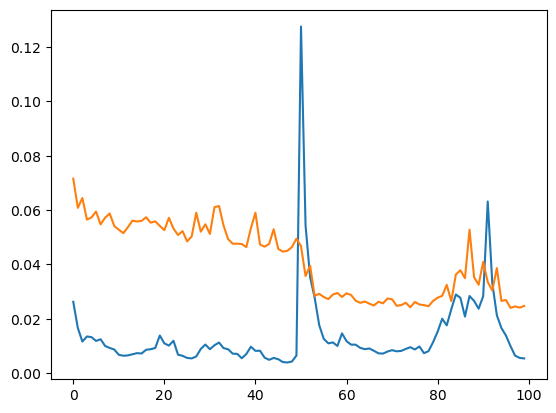

In [96]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)

torch.Size([1, 500, 1]) torch.Size([1, 500, 1])
torch.Size([1, 50, 20, 501])


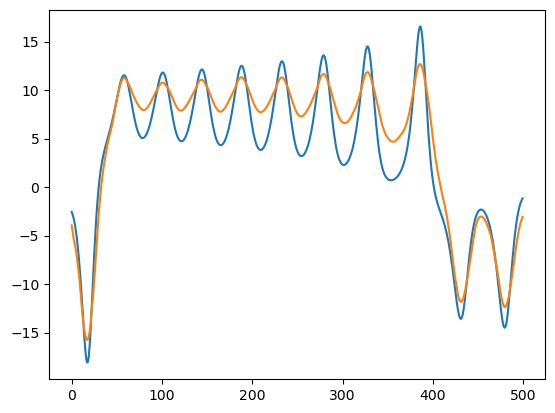

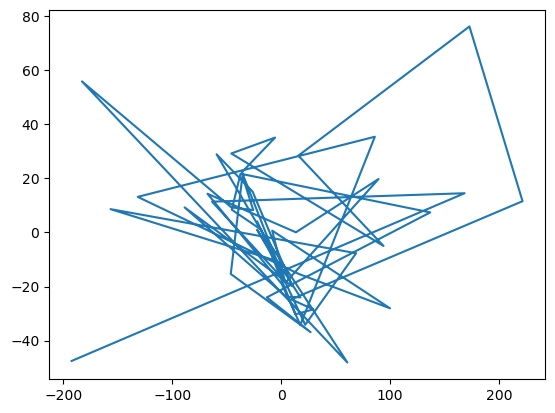

In [102]:
plot_all_hiddens = False
data = next(iter(train_loader))
model.to("cpu")
model.rnn = True
out,hiddens = model(data)

print(data.shape,out.shape)
print(hiddens.shape)
plt.plot(data[0,:,0])
plt.plot(out[0,:,0].detach().numpy())

if plot_all_hiddens:
    fig, ax = plt.subplots(hiddens.shape[1],hiddens.shape[2],figsize=(20,20))
    for i in range(hiddens.shape[1]):
        for j in range(hiddens.shape[2]):
            ax[i,j].plot(hiddens[0,i,j].detach().numpy())

    plt.tight_layout()
else:
    #do PCA on the hidden states
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    hiddens = hiddens[0,:,0]
    hiddens = hiddens.reshape(-1,hiddens.shape[-1])
    hiddens = hiddens.detach().numpy().real
    pca.fit(hiddens)
    hiddens = pca.transform(hiddens)
    plt.figure()
    plt.plot(hiddens[:,0],hiddens[:,1])